In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
!pip install nltk
import nltk
import string
import seaborn as sns
from html.parser import HTMLParser
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.random import sample_without_replacement
nltk.download('wordnet')

     |████████████████████████████████| 368kB 7.6MB/s eta 0:00:01


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jupyterlab/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Data Cleaning
After loading the data, we must clean the data such that it can be presented in a form that the models understand. We cannot simply pass in strings or words to the models. We must pass in columns with numbers that capture the meaning of the sentences presented by the dataset. To create a clean dataset, we execute the following:

## 1. Parse the Stop Words Dataset
- Add and remove stop words that were not recognized or incorrectly identified by the given stop words dataset

In [15]:
# loading data
data_path = "data/"
sa_df = pd.read_csv(data_path + "sentiment_analysis.csv", names=["ID", "text", "label"], low_memory=False)
sa_df = sa_df[1:]

us_df = pd.read_csv(data_path + "US_Elections_2020.csv", names=["text", "sentiment", "negative_reason"], low_memory=False)
us_df = us_df[1:]

stop_words_file = open(data_path + "stop_words.txt")
stop_words_set = set()

index = 0
stop_words_error_set = set([249, 495])
for line in stop_words_file:
    if index in stop_words_error_set:
        index += 1
        continue
    stop_words_set.add(line.replace("\n", ""))
    index += 1

# removing some stop words
stop_words_set.remove("w")
stop_words_set.remove("l")

# adding stop words that were incorrectly parsed in .txt file
stop_words_set.add("keep")
stop_words_set.add("keeps")
stop_words_set.add("sure")
stop_words_set.add("t")

# adding additional slang stop words
stop_words_set.add("ur")

# 2477 lines in corpus.txt
corpus_file_len = 2477
corpus_file = open(data_path + "corpus.txt")
corpus_words = np.array([" " for _ in range(corpus_file_len)], dtype=object)
corpus_counts = np.zeros((corpus_file_len,))

index = 0

def sum_line_array(line_array_splice):
    string = ""
    for word in line_array_splice:
        string += word + " "
    return string[:-1]

for line in corpus_file:
    line_array = line.split()
    corpus_words[index], corpus_counts[index] = sum_line_array(line_array[:-1]), line_array[-1]
    index += 1

corpus_df_dict = {"word": pd.Series(corpus_words), "count": pd.Series(corpus_counts)}
corpus_df = pd.DataFrame(corpus_df_dict)

In [16]:
print("Shape of sentiment analysis DataFrame:", sa_df.shape)
print("Shape of US elections DataFrame:", us_df.shape)
print("Shape of corpus DataFrame:", corpus_df.shape)
print("Length of stop words set:", len(stop_words_set))

Shape of sentiment analysis DataFrame: (550391, 3)
Shape of US elections DataFrame: (2552, 3)
Shape of corpus DataFrame: (2477, 2)
Length of stop words set: 666


In [17]:
print("df.head of sentiment analysis DataFrame:", sa_df.head())
print("\ndf.head of US elections DataFrame:", us_df.head())
print("\ndf.head of corpus DataFrame:", corpus_df.head())

df.head of sentiment analysis DataFrame:             ID                                               text label
1  7.68098E+17  Josh Jenkins is looking forward to TAB Breeder...     1
2  7.68098E+17  RT @MianUsmanJaved: Congratulations Pakistan o...     1
3  7.68098E+17  RT @PEPalerts: This September, @YESmag is taki...     1
4  7.68098E+17  RT @david_gaibis: Newly painted walls, thanks ...     1
5  7.68098E+17  RT @CedricFeschotte: Excited to announce: as o...     1

df.head of US elections DataFrame:                                                 text sentiment negative_reason
1  b'@robreiner so afraid of Nov, Dec, and Jan! E...         0         covid19
2  b"RT @SueC00K: Lord Sumption launches Recovery...         0          others
3  b'RT @WalidPhares: Uber Timing: after #Biden a...         0         covid19
4  b'Every 107 seconds an American is dying from ...         1             NaN
5  b'RT @thewebbix: The #Democrats embrace #Diver...         1             NaN

df.head of corpu

## 2. Clean the Tweet Data
- Remove urls
- Remove the 'b' character at the front of each sentence
- Remove "'" and '"' at the beginning of all tweets
- Remove 'RT'
- Remove mentions and handles
- Replace new lines with spaces
- Replace all HTML tags and attributes
- Replace all HTML character codes using HTML parser
- Remove all of the emojis
- Change the text to lowercase text
- Remove all punctuation

## 3. Tokenize the Tweet Data
- Change each tweet from a sentence "make america great again" into a list of word tokens using the TweetTokenizer ["make", "america", "great", "again"]

## 4. Lemmatize the tokens
- Change each token into a lemmatized form "has" -> "have", "running" -> "run", etc.

## 5. Remove Stop Words and Numbers
- All numbers except for the specified numbers that may convey meaning were removed
- Stop words present in the stop words dataset parsed in step 1 were removed

In [18]:
# cleaning tweet data
tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
token_lemmatizer = nltk.stem.WordNetLemmatizer()

def map_text(tweet):
    input_tweet = tweet
    # removing URLs
    tweet = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', tweet, flags=re.MULTILINE)

    # removing "b" at beginning of all US elections tweets
    tweet = re.sub(r'^b', '', tweet)
 
    # removing "'" and '"' at beginning of all US elections tweets
    tweet = re.sub(r'^[\'"]', '', tweet)

    # removing 'RT'
    tweet = re.sub(r'^RT ', '', tweet)

    # removing mentions and handles
    tweet = re.sub(r'@\S* ?', '', tweet)

    # replacing new lines with spaces
    tweet = re.sub(r'\\n', ' ', tweet)

    # replacing html tags & attributes (/<[^>]+>\) + hashtags (#)
    unwanted_html_elements = "\/<[^>]+>#"    
    for unwanted_element in unwanted_html_elements:
        tweet = tweet.replace(unwanted_element, "")

    
    # replacing html character codes (&...)
    h = HTMLParser()
    tweet = h.unescape(tweet)

    # removing emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # changing text to lowercase
    tweet = tweet.lower()

    # replacing "," and "." with spaces
    tweet = re.sub(r'[,.]', ' ', tweet)

    # removing punctuation
    tweet = re.sub(r'['+string.punctuation+']+s?', '', tweet)

    # tokenizing tweet
    tokenized_tweet = tweet_tokenizer.tokenize(tweet)

    # lemmatizing tokens
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = token_lemmatizer.lemmatize(tokenized_tweet[i])

    # removing stop words & numbers
    clean_tweet = []
    kept_dates = set(["2008", "2016", "2017", "2018", "2019", "2020", "2021"])
    for word in tokenized_tweet:
        if word not in stop_words_set:
            if word in kept_dates or not re.match(r'[0-9]', word): 
                clean_tweet.append(word)

    return clean_tweet


example_tweet_1 = 'b"RT @GayHopper_com: I\'m happy! \n\n#booyah https://t.co/fKXbN3Zhtd"'
print(map_text(example_tweet_1))

example_tweet_2 = "b'@JoeBiden JOE BIDEN IS TOTALLY AND COMPLETELY COMPROMISED BY CHINA.\n\nJoe Biden is a corrupt politician. He wants https://t.co/wuUCpVzOo6'"
print(map_text(example_tweet_2))

example_tweet_3 = "b'#COVID19 #coronavirus #coronavirusuk #COVID #UKlockdown \nIf there is a National Lockdown Next Week \nShould We https://t.co/A7h6gAD2cz'"
print(map_text(example_tweet_3))

example_tweet_4 = "b\"RT @MelissaTweets: I didn't think all the freak out was about control in the beginning of \#Covid.\n\nNow, it's clear that's ALL it's'"
print(map_text(example_tweet_4))

example_tweet_5 = "b'RT @DennisClend23: @amyisfedtfup @GOP @IvankaTrump I wish 90,000 Americans been infected &amp; 900+ died yesterday, along with the 2019 virus"
print(map_text(example_tweet_5))

example_tweet_6 = "b'Share, we need to change this!\n#CHANGES \n#WomensMarch2020 \n#BidenHarris2020 https://t.co/8S90buAjxY'"
print(map_text(example_tweet_6))

example_tweet_7 = "b'RT @TimFaulkner81: @realDonaldTrump Voting ends November 3rd. Then we count ALL VOTES.\n\nYou sound really desperate, Donny.\n\n#BidenHarris2020'"
print(map_text(example_tweet_7))

# applying mapping
sa_df["clean_text"] = sa_df["text"].map(map_text)
us_df["clean_text"] = us_df["text"].map(map_text)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


['happy', 'booyah']
['joe', 'biden', 'totally', 'completely', 'compromised', 'china', 'joe', 'biden', 'corrupt', 'politician']
['covid', 'coronavirus', 'coronavirusuk', 'covid', 'uklockdown', 'national', 'lockdown', 'week']
['didnt', 'freak', 'wa', 'control', 'covid', 'clear']
['american', 'infected', 'died', 'yesterday', '2019', 'virus']
['share', 'change', 'change', 'womensmarch', '2020', 'bidenharris', '2020']
['voting', 'november', 'count', 'vote', 'sound', 'desperate', 'donny', 'bidenharris', '2020']


The above shows examples of how each tweet was parsed and tokenized into a more simple and understandable form. The following tweet:

```
"b'@JoeBiden JOE BIDEN IS TOTALLY AND COMPLETELY COMPROMISED BY CHINA.\n\nJoe Biden is a corrupt politician. 
He wants https://t.co/wuUCpVzOo6'"
```

Was transformed into:

```
['joe', 'biden', 'totally', 'completely', 'compromised', 'china', 'joe', 'biden', 'corrupt', 'politician']
```

Notice that the newline characters, additional punctuation, links, and twitter lingo were all taken care of. The remaining list of words can be vectorized using a vectorizer and then fed into a model. The following are some more examples taken from the general tweet dataset:

In [19]:
for i in range(1, 300):
    print("\nOriginal Text:\n", sa_df["text"][i])
    print("\nClean Text:\n", sa_df["clean_text"][i])


Original Text:
 Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0

Clean Text:
 ['josh', 'jenkins', 'forward', 'tab', 'breeder', 'crown', 'super', 'sunday']

Original Text:
 RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…

Clean Text:
 ['congratulation', 'pakistan', 'no1testteam', 'odds', 'jipakzindabadrallies']

Original Text:
 RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…

Clean Text:
 ['september', 'maine', 'mendozas', 'surprise', 'thanksgiving', 'party', 'threw', 'fan']

Original Text:
 RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer.  Great job ladies!!!#EC_proud https://t.co/…

Clean Text:
 ['newly', 'painted', 'wall', 'custodial', 'painter', 'summer', 'great', 'job', 'ladiesecproud']


In [13]:
print("Sentiment analysis df.head():\n", sa_df.head())

Sentiment analysis df.head():
             ID                                               text label  \
1  7.68098E+17  Josh Jenkins is looking forward to TAB Breeder...     1   
2  7.68098E+17  RT @MianUsmanJaved: Congratulations Pakistan o...     1   
3  7.68098E+17  RT @PEPalerts: This September, @YESmag is taki...     1   
4  7.68098E+17  RT @david_gaibis: Newly painted walls, thanks ...     1   
5  7.68098E+17  RT @CedricFeschotte: Excited to announce: as o...     1   

                                          clean_text  \
1  [josh, jenkins, forward, tab, breeder, crown, ...   
2  [congratulation, pakistan, no1testteam, odds, ...   
3  [september, maine, mendozas, surprise, thanksg...   
4  [newly, painted, wall, custodial, painter, sum...   
5  [excited, july, 2017, feschotte, lab, will, re...   

                                     clean_sentences  
1  josh jenkins forward tab breeder crown super s...  
2  congratulation pakistan no1testteam odds jipak...  
3  september mai

Since we preserved the empty tweets, we will now investigate the sentiments of empty tweets:

In [14]:
sa_df_empty_tweet_mask = sa_df["clean_text"].apply(lambda x: len(x) == 0)
empty_tweet_count = sum(sa_df_empty_tweet_mask)
print("Empty Tweet count =", empty_tweet_count)

positive_empty_tweets = sum(sa_df["label"][sa_df_empty_tweet_mask].astype(int))
print("Number of positive empty Tweets = {} ({}%)".format(positive_empty_tweets, round(positive_empty_tweets/empty_tweet_count *100, 3)))
del sa_df_empty_tweet_mask

Empty Tweet count = 1864
Number of positive empty Tweets = 1167 (62.607%)


62.6% of empty tweets have positive sentiment. Therefore, if the model predicts that every tweet that is empty is positive it will have a 62.6% chance of guessing correctly. The following visualizes the data cleaning results for the US tweet dataset:

In [15]:
print("US elections df original and clean Tweet visualization:")
for i in range(1, 300):
    print("\nIndex =", i)
    print("Original Text:\n", us_df["text"][i])
    print("Clean Text:\n", us_df["clean_text"][i])

poor', 'middle', 'class']

Index = 217
Original Text:
 b'RT @USCenturion2020: I want this Truck.#KAG #trump220 https://t.co/7dPHORzi52'
Clean Text:
 ['truck', 'kag', 'trump']

Index = 218
Original Text:
 b"#FridayThoughts \n#Halloween\nScary to see Twitter has a disclaimer about misleading political information but https://t.co/mmXesaa6yz"
Clean Text:
 ['fridaythoughts', 'halloween', 'scary', 'twitter', 'ha', 'disclaimer', 'misleading', 'political']

Index = 219
Original Text:
 b'RT @originalmule: What a scam...#COVID19 @GovWhitmer #politics https://t.co/ChKNWud7zO'
Clean Text:
 ['scam', 'covid', 'politics']

Index = 220
Original Text:
 b'@cekoenig @BostonGlobe Just like #Gays #Blacks #Jews. Endorsing #Trump is ignoring the #Democrat hate and https://t.co/6yviuukttq'
Clean Text:
 ['gay', 'black', 'jew', 'endorsing', 'trump', 'ignoring', 'democrat', 'hate']

Index = 221
Original Text:
 b'@JoeBiden Trump #MAGA \nMake America Great Again\n\nBiden #MCHGA\nMake China Great Again\n\nTrump #M

# Exploratory Analysis
To determine the political party of a given tweet, we have created a list of republican and democratic buzzwords. Tweets with these buzzwords will be classified as either democratic or republican and tweets that do not contain these buzzwords will be classified as unclassified. 

In [16]:
republican_buzzwords = set(["maga", "keepamericagreat", "trumppence", "buildthewall", "sleepyjoe", "chinajoe", "blackvoicesfortrump", "hunterbiden", "veteransfortrump", "redwave", "corruptjoebiden", "fakenews"])
republican_compound_buzzwords = set(["trump2020", "trumppence2020", "votedtrump"])

democrat_buzzwords = set(["bidenharris", "blacklivesmatter", "trumpvirus", "trumpcrimefamily", "bidenharristosaveamerica", "trumpiscompromised", "trumppandemic", "bluewave", "votetrumpout", "votehimout"])
democrat_compound_buzzwords = set(["biden2020", "bidenharris2020", "bidenharris"])

def classify_party(tweet_words):
    compound_words = set()
    for i in range(len(tweet_words)-1):
        compound_words.add(tweet_words[i] + tweet_words[i+1])
    

    # 0 = democrat
    if len(set(tweet_words).intersection(democrat_buzzwords)) > 0 or len(compound_words.intersection(democrat_compound_buzzwords)) > 0:
        return 0  
    # 1 = republican  
    elif len(set(tweet_words).intersection(republican_buzzwords)) > 0 or len(compound_words.intersection(republican_compound_buzzwords)) > 0:
        return 1
    # 2 = unclassified
    else:
        return 2

us_df["party"] = us_df["clean_text"].map(classify_party)

In [17]:
print("Number of left-leaning tweets:", sum(us_df["party"] == 0))
print("Number of right-leaning tweets:", sum(us_df["party"] == 1))
print("Number of unclassified tweets:", sum(us_df["party"] == 2))

Number of left-leaning tweets: 452
Number of right-leaning tweets: 159
Number of unclassified tweets: 1941


We can see that the number of left-leaning tweets (452) is far greater than the number of right-leaning tweets (159). Based on these buzzwords alone, it is difficult to classify many of these tweets. That is why there are 1941 unclassified tweets. 

We will now visualize the distribution of positive and negative tweets in the generic tweet dataset. We will also consider the word count for each tweet because this could provide insight into the likelihood that a tweet is positive or negative. If it was more likely that a tweet with 10 words was positive than it was negative then this would be useful information to know. Visualizing this distribution is useful. 

In [18]:
sa_df["word_counts"] = sa_df["clean_text"].apply(lambda x: len(x))

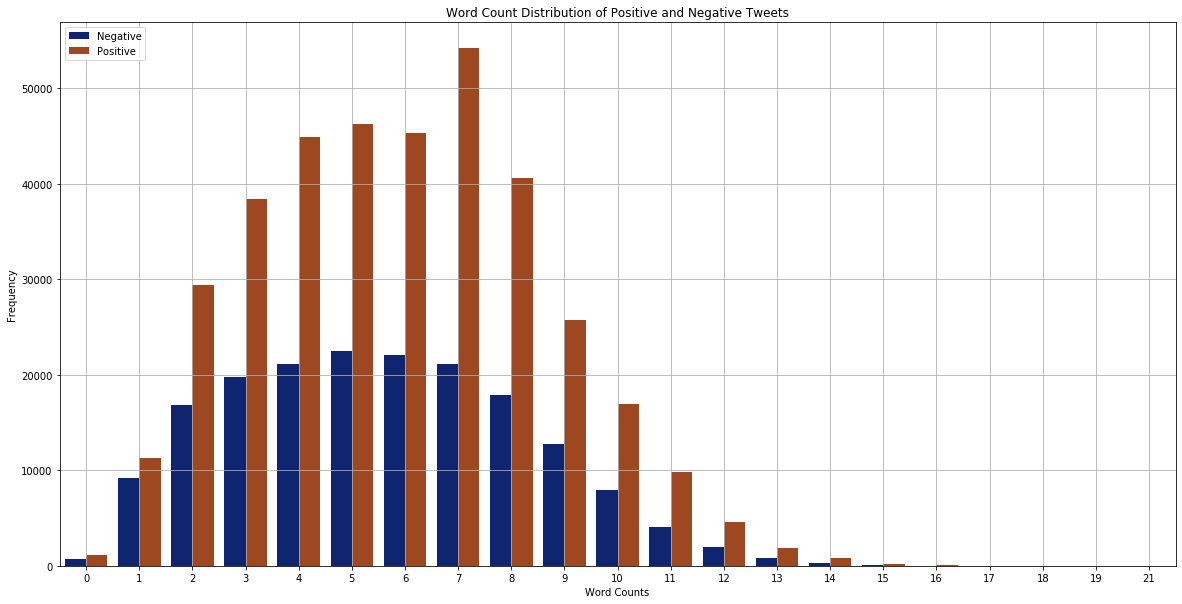

In [15]:
f, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x="word_counts", hue="label", data=sa_df, palette="dark")
ax.legend(["Negative", "Positive"])
plt.grid(True)
plt.title("Word Count Distribution of Positive and Negative Tweets")
plt.xlabel("Word Counts")
plt.ylabel("Frequency")
plt.show()

As we can see from the above Figure, the negative and positive tweet distributions are normal with respect to word count. There are far more positive tweets than negative tweets. When a tweet has 7 words, we can see that the likelihood that it is positive is significantly greater than the likelihood that a tweet would be positive for different word counts. 

For the US tweet dataset, we will visualize the most commonly used words.

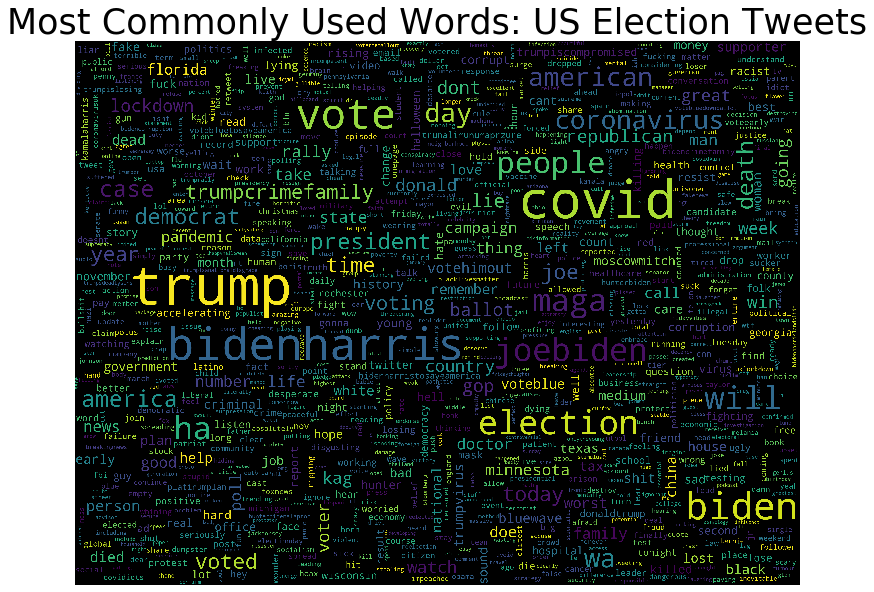

In [16]:
us_clean_text_list = list(us_df['clean_text'])
flat_us_clean_text = [item for sublist in us_clean_text_list for item in sublist]

wordcloud = WordCloud(max_font_size=300, max_words=1000, width=4000, height=3000,collocations=False).generate(" ".join(flat_us_clean_text))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Most Commonly Used Words: US Election Tweets',fontsize=35)
plt.axis("off")
plt.show()

This plot is an interesting one. The most common words are consistent with the culture surrounding the US election. The coronavirus is one of the most pressing issues facing Americans today and that is illustrated by the size of the word "covid". We also see words like "racist", "trumpcrimefamily", "maga", and "lie" appearing in rather large fonts. These words signify the trust that the American people lack for their governing body. The divide between democrats and republicans is growing and that is signified by the appearance of words like "fake", "corrupt", and "hunter" (likely in reference to Hunter Biden). 

# Model Preparation
Now that we have visualized the data, we will begin designing models to predict the sentiments of these tweets. The following process was followed:

## 1. Create a Sentences Column for Vectorization
- BoW and TF-IDF vectorizers require sentences as input. Recreating a sentences column was the fastest way to create this input.

In [6]:
def create_sentences(tweet):
    # removing URLs
    tweet = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', tweet, flags=re.MULTILINE)

    # removing "b" at beginning of all US elections tweets
    tweet = re.sub(r'^b', '', tweet)
 
    # removing "'" and '"' at beginning of all US elections tweets
    tweet = re.sub(r'^[\'"]', '', tweet)

    # removing 'RT'
    tweet = re.sub(r'^RT ', '', tweet)

    # removing mentions and handles
    tweet = re.sub(r'@\S* ?', '', tweet)

    # replacing new lines with spaces
    tweet = re.sub(r'\\n', ' ', tweet)

    # replacing html tags & attributes (/<[^>]+>\) + hashtags (#)
    unwanted_html_elements = "\/<[^>]+>#"    
    for unwanted_element in unwanted_html_elements:
        tweet = tweet.replace(unwanted_element, "")

    # replacing html character codes (&...)
    h = HTMLParser()
    tweet = h.unescape(tweet)

    # removing emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')

    # changing text to lowercase
    tweet = tweet.lower()

    # replacing "," and "." with spaces
    tweet = re.sub(r'[,.]', ' ', tweet)

    # removing punctuation
    tweet = re.sub(r'['+string.punctuation+']+s?', '', tweet)

    # tokenizing tweet
    tokenized_tweet = tweet_tokenizer.tokenize(tweet)

    # lemmatizing tokens
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = token_lemmatizer.lemmatize(tokenized_tweet[i])

    # removing stop words & numbers & creating sentence
    sentence = ""
    kept_dates = set(["2008", "2016", "2017", "2018", "2019", "2020", "2021"])
    for word in tokenized_tweet:
        if word not in stop_words_set:
            if word in kept_dates or not re.match(r'[0-9]', word): 
                sentence = sentence + word + " "

    return sentence

sa_df["clean_sentences"] = sa_df["text"].map(create_sentences)
us_df["clean_sentences"] = us_df["text"].map(create_sentences)

/home/atkinssamuel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


## 2. Data Splitting 
- 70/30 Training/Testing
- Only a subset of the general tweet dataset was used because running each of these models using the entire dataset takes hours
    - 1/5th of the data was randomly extracted using a random seed to retain the distribution of the original dataset

## 3. Bag of Words Model Implementation
- The Logistic Regression, kNN, Naive Bayes, SVM, RF, and XGBoost models were implemented using 2000 features and the Bag of Words approach
- CV and hyperparameter tuning was not performed
    - According to https://piazza.com/class/kf4i6j798xu1ri?cid=127 hyperparameter tuning is only required when training on the US elections data.
    - This is justified because we observed testing accuracies of 93% and above using the default models. Further, this is justified because performing hyperparameter tuning using a dataset of this size with my environment would take days. The expected improvement is not worth the time that it would take to finely tune an optimal model. 
- LinearSVM was used as opposed to SVM. Using one or the other is purely situational. In this context, LinearSVM was explored because it converges quicker, thus saving computing time.  

In [7]:
us_df.head()

,text,sentiment,negative_reason,clean_text,clean_sentences
1,"b'@robreiner so afraid of Nov, Dec, and Jan! E...",0,covid19,"[afraid, nov, dec, jan, bidenharris, 2020, win...",afraid nov dec jan bidenharris 2020 win frump ...
2,"b""RT @SueC00K: Lord Sumption launches Recovery...",0,others,"[lord, sumption, launch, recovery, initiative,...",lord sumption launch recovery initiative promo...
3,b'RT @WalidPhares: Uber Timing: after #Biden a...,0,covid19,"[uber, timing, biden, advisor, pressure, brazi...",uber timing biden advisor pressure brazil sanc...
4,b'Every 107 seconds an American is dying from ...,1,NaN,"[second, american, dying, trumpvirus, donaldtr...",second american dying trumpvirus donaldtrump s...
5,b'RT @thewebbix: The #Democrats embrace #Diver...,1,NaN,"[democrat, embrace, diversityandinclusion, cit...",democrat embrace diversityandinclusion citizen...


In [36]:
sa_df.head()

,ID,text,label,clean_text,clean_sentences,word_counts
1,7.68098E+17,Josh Jenkins is looking forward to TAB Breeder...,1,"[josh, jenkins, forward, tab, breeder, crown, ...",josh jenkins forward tab breeder crown super s...,8
2,7.68098E+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1,"[congratulation, pakistan, no1testteam, odds, ...",congratulation pakistan no1testteam odds jipak...,5
3,7.68098E+17,"RT @PEPalerts: This September, @YESmag is taki...",1,"[september, maine, mendozas, surprise, thanksg...",september maine mendozas surprise thanksgiving...,8
4,7.68098E+17,"RT @david_gaibis: Newly painted walls, thanks ...",1,"[newly, painted, wall, custodial, painter, sum...",newly painted wall custodial painter summer gr...,9
5,7.68098E+17,RT @CedricFeschotte: Excited to announce: as o...,1,"[excited, july, 2017, feschotte, lab, will, re...",excited july 2017 feschotte lab will relocatin...,8


In [14]:
sa_df_sample_indices = sample_without_replacement(n_population=sa_df.shape[0], n_samples=round(sa_df.shape[0]/5), random_state=88) 

sa_df_sample = sa_df.iloc[sa_df_sample_indices]
print(sa_df_sample.shape)

(110078, 5)


In [193]:
num_features = 2000

# bag of words
# sa_df
vectorizer = CountVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# splitting data
us_dfy = us_df["sentiment"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

In [53]:
print(sa_dfx.toarray().shape)
print(sa_dfy.shape)

(110078, 2000)
(110078,)


In [52]:
print(us_dfx.toarray().shape)
print(us_dfy.shape)

(2552, 2000)
(2552,)


In [7]:
def k_fold_cv(model, k, X_train, y_train):
    kfold = KFold(n_splits=k)
    kfold.get_n_splits(X_train)

    accuracy = np.zeros(10)
    np_idx = 0


    for train_idx, test_idx in kfold.split(X_train):
        k_X_train, k_X_test = X_train[train_idx], X_train[test_idx]
        k_y_train, k_y_test = y_train.values[train_idx], y_train.values[test_idx]
        
        model.fit(k_X_train, k_y_train)
        
        predictions = model.predict(k_X_test)

        cm = confusion_matrix(k_y_test, predictions)
        total = sum(sum(cm))
        correct = 0
        for i in range(len(cm)):
            correct += cm[i][i]
        ACC = correct/total
    
        
        accuracy[np_idx] = ACC*100
        np_idx += 1
        
        print("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

    print("Average Score: {}%".format(round(np.mean(accuracy), 3)))
    print("Accuracy Standard Deviation: {}".format(round(np.std(accuracy), 3)))
    print("Accuracy Variance: {}".format(round(np.square(np.std(accuracy)), 3)))

    # returns accuracy and variance
    return np.mean(accuracy), np.square(np.std(accuracy))


def evaluate_model(model, X_train, y_train):
    _X_train, _X_valid, _y_train, _y_valid = train_test_split(X_train, y_train, random_state=88, test_size=0.3)

    model.fit(_X_train, _y_train)

    predictions = model.predict(_X_valid)
    
    cm = confusion_matrix(_y_valid, predictions)
    total = sum(sum(cm))
    correct = 0
    for i in range(len(cm)):
        correct += cm[i][i]
    ACC = correct/total
    
    
    print("Model Accuracy: {}%".format(round(ACC*100,3)))

def test_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    cm = confusion_matrix(y_test, predictions)
    total = sum(sum(cm))
    correct = 0
    for i in range(len(cm)):
        correct += cm[i][i]
    ACC = correct/total
    
    
    print("Model Accuracy: {}%".format(round(ACC*100,3)))

In [194]:
# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 93.022%

Model performance on general tweet test set:
Model Accuracy: 92.99%

Model performance on US election tweet test set:
Model Accuracy: 63.708%


In [89]:
# kNN - works, but takes a very long time
model = KNeighborsClassifier(n_neighbors=1)
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 82.355%

Model performance on general tweet test set:
Model Accuracy: 82.208%

Model performance on US election tweet test set:
Model Accuracy: 53.958%


In [84]:
# Naive Bayes
model = GaussianNB()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 79.664%

Model performance on general tweet test set:
Model Accuracy: 79.691%

Model performance on US election tweet test set:
Model Accuracy: 54.83%


In [85]:
# SVM SVC - works, but takes a very long time
# model = SVC()
model = LinearSVC()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 92.741%

Model performance on general tweet test set:
Model Accuracy: 92.778%

Model performance on US election tweet test set:
Model Accuracy: 63.708%


In [86]:
# Decision Tree Classifier
model = DecisionTreeClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 90.081%

Model performance on general tweet test set:
Model Accuracy: 89.81%

Model performance on US election tweet test set:
Model Accuracy: 61.619%


In [87]:
# Random Forest Classifier
model = RandomForestClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 91.573%

Model performance on general tweet test set:
Model Accuracy: 91.688%

Model performance on US election tweet test set:
Model Accuracy: 65.666%


In [88]:
# Gradient Boosting Classifier
model = GradientBoostingClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 80.227%

Model performance on general tweet test set:
Model Accuracy: 80.211%

Model performance on US election tweet test set:
Model Accuracy: 62.402%


## 4. TF-IDF Model Implementation

In [90]:
num_features = 2000

# tf-idf
# sa_df
vectorizer = TfidfVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# splitting data
us_dfy = us_df["sentiment"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

In [91]:
# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 92.962%

Model performance on general tweet test set:
Model Accuracy: 92.987%

Model performance on US election tweet test set:
Model Accuracy: 63.577%


In [92]:
# kNN - works, but takes a very long time
model = KNeighborsClassifier(n_neighbors=1)
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 83.648%

Model performance on general tweet test set:
Model Accuracy: 83.511%

Model performance on US election tweet test set:
Model Accuracy: 56.265%


In [93]:
# Naive Bayes
model = GaussianNB()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 82.788%

Model performance on general tweet test set:
Model Accuracy: 82.822%

Model performance on US election tweet test set:
Model Accuracy: 55.614%


In [94]:
# SVM SVC - works, but takes a very long time
# model = SVC()
model = LinearSVC()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 92.759%

Model performance on general tweet test set:
Model Accuracy: 92.926%

Model performance on US election tweet test set:
Model Accuracy: 63.055%


In [95]:
# Decision Tree Classifier
model = DecisionTreeClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 89.497%

Model performance on general tweet test set:
Model Accuracy: 89.729%

Model performance on US election tweet test set:
Model Accuracy: 63.446%


In [96]:
# Random Forest Classifier
model = RandomForestClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 91.79%

Model performance on general tweet test set:
Model Accuracy: 91.812%

Model performance on US election tweet test set:
Model Accuracy: 62.924%


In [97]:
# Gradient Boosting Classifier
model = GradientBoostingClassifier()
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on general tweet test set:")
test_model(model, sa_X_test, sa_y_test)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 79.859%

Model performance on general tweet test set:
Model Accuracy: 79.827%

Model performance on US election tweet test set:
Model Accuracy: 62.272%


## 5. Optimal Model Evaluation
- The optimal model is the model that maximizes the testing accuracy on the generic tweet dataset. This model is the logistic regression model. It obtained a testing accuracy of 92.99% using 2000 features and the bag of words approach. 
- This model has been evaluated on the US elections test dataset below:

In [35]:
num_features = 2000

# bag of words
# sa_df
vectorizer = CountVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# splitting data
us_dfy = us_df["sentiment"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")
print("Model performance on general tweet validation set:")
evaluate_model(model, sa_X_train, sa_y_train)
print("\nModel performance on US election tweet test set:")
test_model(model, us_X_test, us_y_test)

Model performance on general tweet validation set:
Model Accuracy: 93.022%

Model performance on US election tweet test set:
Model Accuracy: 63.708%


From the above we can see that this model obtained a testing accuracy of 63.708% on the US elections test dataset. This is quite poor compared to the 92.99% observed on the generic tweet testing set. Compared to the 50.47% accuracy that would have been obtained if the mode was guessed, this is a considerable improvement. There are a few reasons that this accuracy value is significantly lower than the 92.99% testing accuracy observed on the generic tweet dataset. Two of these reasons are explained below:

1. The generic tweet dataset and the US elections dataset are fundamentally different. Given that a small subset of the generic tweet dataset pertains to the election, the model will not perform strongly when only exposed to this type of data. 
2. The distributions of the target variables are different. The outputs of the generic tweet dataset are primarily positive (67.4%) whilst the outputs of the US elections dataset are almost evenly split (50.47/49.53, see below). This will have an impact on the performance of the model because given that the model was trained on a dataset that was more likely to be positive, the model is biased towards positive sentiments. This bias results in inaccuracies when the model is applied to a balanced dataset like the US elections dataset. 

In [36]:
print("Percentage of positive generic tweets = {}%".format(round(sa_dfy[sa_dfy.astype(int) == 1].shape[0] / sa_dfy.shape[0] * 100, 2)))
print("Percentage of positive US election tweets = {}%".format(round(us_dfy[us_dfy.astype(int) == 1].shape[0] / us_dfy.shape[0] * 100, 2)))

Percentage of positive generic tweets = 67.4%
Percentage of positive US election tweets = 50.47%


We will now visualize the sentiment prediction results. To do this, we will create a confusion matrix dataframe that illustrates the predicted and true values of the features. From this, we can compute the precision and recall of both the positive and negative sentiment categories:

In [131]:
num_features = 2000

# bag of words
# sa_df
vectorizer = CountVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# splitting data
us_dfy = us_df["sentiment"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")

model.fit(sa_X_train, sa_y_train)

predictions = model.predict(us_X_test)

cm = confusion_matrix(us_y_test, predictions)

print("Confusion Matrix:\n", cm)
print("\nSum Along Rows of Confusion Matrix:\n", np.sum(cm, axis=1))

print("\n", us_y_test.value_counts())


cm_df = pd.DataFrame(cm, columns=["predicted_0", "predicted_1"], index=[0, 1])

print("\n\n CM DF:\n", cm_df)

cm = np.array(cm)

print("\n")
for i in range(2):
    print("sentiment =", i)
    print("precision =", round(cm[i, i]/sum(cm[:, i]), 2))
    print("recall =", round(cm[i, i]/sum(cm[i, :]), 2), "\n")

Confusion Matrix:
 [[331  30]
 [248 157]]

Sum Along Rows of Confusion Matrix:
 [361 405]

 1    405
0    361
Name: sentiment, dtype: int64


 CM DF:
    predicted_0  predicted_1
0          331           30
1          248          157


sentiment = 0
precision = 0.57
recall = 0.92 

sentiment = 1
precision = 0.84
recall = 0.39 



From the confusion matrix we can see how many times the model predicted a sentiment of 0/1 and how many times the true value was 0/1. We also can see that the recall for negative sentiments is very high. This means that whever the true value was 0, the model predicted 0 92% of the time. The recall for 1, on the other hand, was quite low. This is likely because the majority of the true values present in the data are 0. 

To visualize the true sentiment for each of the two parties/candidates, we will split our data into republican and democratic based on the metrics we defined before:

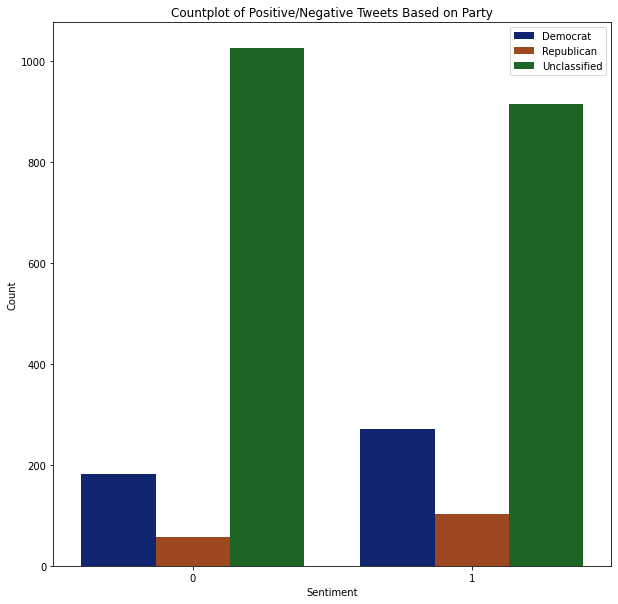

In [160]:
democrat = us_df[us_df["party"] == 0]
repub = us_df[us_df["party"] == 1]

plt.figure(figsize=(10, 10))
sns.countplot(x="sentiment", data=us_df, hue="party", palette="dark")
plt.legend(["Democrat", "Republican", "Unclassified"])
plt.title("Countplot of Positive/Negative Tweets Based on Party")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

From the above, we can see that the tweets that were easily identified by our metrics as democratic or republican were more positive than negative. It does not appear that there is a significant difference between how negative one party is compared to the other. Both parties seem to have a positive/negative tweet ratio based on the tweets that we were able to successfully classify. 

Regarding the applicability of NLP to US election tweet data, perhaps it could be useful in certain contexts. For example, campaigns could infer which buzzwords occurred most frequently amongst the negative tweets from the opposing party. This would help them locate areas of weakness within their own campaign that they could then address. Unfortunately, the middle ground in America is shrinking as more and more people become entrenched in their views. Twitter users ranting about the GOP or fake news likely won't swing to the other party. Basing your campaign strategy on the collective opinion of the Twitter mob doesn't really make sense to me. 

In the context of the democratic/republican primary, tweet analysis could be a good way to benchmark how much attention you are garnering online. President Trump, perhaps more than anyone, understands that there is no such thing as bad press. By classifying Tweets as merely being affiliated with a particular candidate you could get a good feeling for how each candidate is fairing.

# Model Implementation and Tuning
For this section the 2020 US elections data with negative sentiment labels will be extracted. Using these negatively labelled data entries, we will design and implement models to predict the reason for the negative tweet. The selected classification algorithms are logistic regression, SVM, and random forest. Hyperparameter tuning with 10-fold cross validation was performed to determine the optimal parameters for each model. 

In [57]:
negative_us = us_df[us_df["sentiment"].astype(float) == False]

# tf-idf
vectorizer = CountVectorizer(max_features=2000)
us_dfx = vectorizer.fit_transform(negative_us["clean_sentences"])

# splitting data
us_dfy = negative_us["negative_reason"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

In [47]:
print(us_dfy.unique())

['covid19' 'others' 'discrimination' 'corruption' 'crime']


In [58]:
# logistic regression
k = 10
best_model = None
best_accuracy = 0
for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        for regularization_type in ["l1", "l2"]:
            if  regularization_type == "l1" and solver in set(['newton-cg', 'sag', 'lbfgs']):
                continue
            model = LogisticRegression(C=C, solver=solver, penalty=regularization_type)

            print("\nC = {}, Solver = {}, Penalty = {}".format(C, solver, regularization_type))
            cv_acc, cv_var = k_fold_cv(model, k, us_X_train, us_y_train)

            if cv_acc > best_accuracy:
                best_accuracy = cv_acc
                best_model = "\nC = {}, Solver = {}, Penalty = {}, Accuracy = {}%, Var = {}".format(C, solver, regularization_type, round(cv_acc, 3), round(cv_var, 3))
print(best_model)


C = 0.001, Solver = newton-cg, Penalty = l2
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 31.461%
Fold 3: Accuracy: 26.966%
Fold 4: Accuracy: 30.337%
Fold 5: Accuracy: 32.955%
Fold 6: Accuracy: 37.5%
Fold 7: Accuracy: 35.227%
Fold 8: Accuracy: 32.955%
Fold 9: Accuracy: 40.909%
Fold 10: Accuracy: 26.136%
Average Score: 32.815%
Accuracy Standard Deviation: 4.253
Accuracy Variance: 18.09

C = 0.001, Solver = lbfgs, Penalty = l2
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 31.461%
Fold 3: Accuracy: 26.966%
Fold 4: Accuracy: 30.337%
Fold 5: Accuracy: 32.955%
Fold 6: Accuracy: 37.5%
Fold 7: Accuracy: 35.227%
Fold 8: Accuracy: 32.955%
Fold 9: Accuracy: 40.909%
Fold 10: Accuracy: 26.136%
Average Score: 32.815%
Accuracy Standard Deviation: 4.253
Accuracy Variance: 18.09

C = 0.001, Solver = liblinear, Penalty = l1
Fold 1: Accuracy: 20.225%
Fold 2: Accuracy: 14.607%
Fold 3: Accuracy: 20.225%
Fold 4: Accuracy: 17.978%
Fold 5: Accuracy: 21.591%
Fold 6: Accuracy: 15.909%
Fold 7: Accuracy: 14.773%
Fol

In [59]:
# Linear SVC
k = 10
best_model = None
best_accuracy = 0
for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5]:
    for loss in ["hinge", "squared_hinge"]:
        for class_weight in [None, "balanced"]:
            model = LinearSVC(loss=loss, C=C, class_weight=class_weight)
            
            print("\nloss = {}, C = {}, class-weight = {}".format(loss, C, class_weight))
            cv_acc, cv_var = k_fold_cv(model, k, us_X_train, us_y_train)

            if cv_acc > best_accuracy:
                best_accuracy = cv_acc
                best_model = "\nloss = {}, C = {}, class-weight = {}, Accuracy = {}%, Var = {}".format(loss, C, class_weight, round(cv_acc, 3), round(cv_var, 3))
    print(best_model)



loss = hinge, C = 0.001, class-weight = None
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 31.461%
Fold 3: Accuracy: 26.966%
Fold 4: Accuracy: 30.337%
Fold 5: Accuracy: 32.955%
Fold 6: Accuracy: 37.5%
Fold 7: Accuracy: 35.227%
Fold 8: Accuracy: 32.955%
Fold 9: Accuracy: 40.909%
Fold 10: Accuracy: 26.136%
Average Score: 32.815%
Accuracy Standard Deviation: 4.253
Accuracy Variance: 18.09

loss = hinge, C = 0.001, class-weight = balanced
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 31.461%
Fold 3: Accuracy: 26.966%
Fold 4: Accuracy: 30.337%
Fold 5: Accuracy: 32.955%
Fold 6: Accuracy: 37.5%
Fold 7: Accuracy: 35.227%
Fold 8: Accuracy: 32.955%
Fold 9: Accuracy: 40.909%
Fold 10: Accuracy: 26.136%
Average Score: 32.815%
Accuracy Standard Deviation: 4.253
Accuracy Variance: 18.09

loss = squared_hinge, C = 0.001, class-weight = None
Fold 1: Accuracy: 34.831%
Fold 2: Accuracy: 32.584%
Fold 3: Accuracy: 28.09%
Fold 4: Accuracy: 31.461%
Fold 5: Accuracy: 32.955%
Fold 6: Accuracy: 38.636%
Fold 7: Acc

In [60]:
# RF
k = 10
best_model = None
best_accuracy = 0
for n_trees in [10, 50, 100, 500, 1000]:
    for criterion in ["gini", "entropy"]:
        model = RandomForestClassifier(n_estimators=n_trees, criterion=criterion)

        print("\nn_trees = {}, criterion = {}".format(n_trees, criterion))
        cv_acc, cv_var = k_fold_cv(model, k, us_X_train, us_y_train)

        if cv_acc > best_accuracy:
            best_accuracy = cv_acc
            best_model = "\nn_trees = {}, criterion = {}, Accuracy = {}%, Var = {}".format(n_trees, criterion, round(cv_acc, 3), round(cv_var, 3))
print(best_model)



n_trees = 10, criterion = gini
Fold 1: Accuracy: 32.584%
Fold 2: Accuracy: 38.202%
Fold 3: Accuracy: 34.831%
Fold 4: Accuracy: 34.831%
Fold 5: Accuracy: 37.5%
Fold 6: Accuracy: 36.364%
Fold 7: Accuracy: 32.955%
Fold 8: Accuracy: 36.364%
Fold 9: Accuracy: 36.364%
Fold 10: Accuracy: 37.5%
Average Score: 35.749%
Accuracy Standard Deviation: 1.811
Accuracy Variance: 3.279

n_trees = 10, criterion = entropy
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 35.955%
Fold 3: Accuracy: 33.708%
Fold 4: Accuracy: 35.955%
Fold 5: Accuracy: 38.636%
Fold 6: Accuracy: 36.364%
Fold 7: Accuracy: 30.682%
Fold 8: Accuracy: 32.955%
Fold 9: Accuracy: 32.955%
Fold 10: Accuracy: 35.227%
Average Score: 34.614%
Accuracy Standard Deviation: 2.141
Accuracy Variance: 4.583

n_trees = 50, criterion = gini
Fold 1: Accuracy: 33.708%
Fold 2: Accuracy: 37.079%
Fold 3: Accuracy: 35.955%
Fold 4: Accuracy: 38.202%
Fold 5: Accuracy: 37.5%
Fold 6: Accuracy: 32.955%
Fold 7: Accuracy: 30.682%
Fold 8: Accuracy: 36.364%
Fold 9: Acc

As shown above, grid-search determined that the optimal model is a random forest model with n_trees = 1000 and gini criterion. Using this model, we can predict on the testing dataset to characterize the success of this model. 

In [80]:
optimal_model = RandomForestClassifier(n_estimators=1000, criterion="gini")
optimal_model.fit(us_X_train, us_y_train)
predictions = optimal_model.predict(us_X_test)

cm = confusion_matrix(us_y_test, predictions)
total = sum(sum(cm))
correct = 0
for i in range(len(cm)):
    correct += cm[i][i]
ACC = correct/total


print("Model Accuracy on Test Set: {}%".format(round(ACC*100,3)))

Model Accuracy on Test Set: 33.421%


An accuracy of 33.421% is observed. To visualize the negative reason prediction results and the true negative reason, we will display the confusion matrix along with the labels:

In [93]:
print("Confusion Matrix:\n", cm)
print("\nSum Along Rows of Confusion Matrix:\n", np.sum(cm, axis=1))

print("\n", us_y_test.value_counts())
reason_list = ["corruption", "covid19", "crime", "discrimination", "other"]

cm_df = pd.DataFrame(cm, columns=["corruption_pred", "covid19_pred", "crime_pred", "discrimination_pred", "other_pred"], index=reason_list)

print("\n\n CM DF:\n", cm_df)

Confusion Matrix:
 [[ 9 43  5  2  2]
 [ 5 93  6  7  4]
 [ 7 46  8  3  6]
 [ 7 47  2 12  4]
 [ 0 52  2  3  5]]

Sum Along Rows of Confusion Matrix:
 [ 61 115  70  72  62]

 covid19           115
discrimination     72
crime              70
others             62
corruption         61
Name: negative_reason, dtype: int64


 CM DF:
                 corruption_pred  covid19_pred  crime_pred  \
corruption                    9            43           5   
covid19                       5            93           6   
crime                         7            46           8   
discrimination                7            47           2   
other                         0            52           2   

                discrimination_pred  other_pred  
corruption                        2           2  
covid19                           7           4  
crime                             3           6  
discrimination                   12           4  
other                             3           5  


In [97]:
cm = np.array(cm)

for i in range(5):
    print(reason_list[i])
    print("precision =", round(cm[i, i]/sum(cm[:, i]), 2))
    print("recall =", round(cm[i, i]/sum(cm[i, :]), 2), "\n")


corruption
precision = 0.32
recall = 0.15 

covid19
precision = 0.33
recall = 0.81 

crime
precision = 0.35
recall = 0.11 

discrimination
precision = 0.44
recall = 0.17 

other
precision = 0.24
recall = 0.08 



The recall for all of the reasons except for "covid19" are low. This means that our model is heavily biased towards choosing "covid19" as the negative reason. In the results section we will discuss this bias and other factors as to why this model did such a poor job predicting the reasons behind these negative tweets. 

# Results and Discussion
- Answering the research question: What can public opinion on Twitter tell us about the US political landscape in 2020?
- Describe the results of the analysis and interpret the results + explain how each party is viewed in the public eye based on the sentiment value

The data tells us a lot about what the users that are tweeting are feeling. From the plots in the data exploration section we noticed that many of the words that appeared signified a distrust that Twitter users had with both the current administration and the Joe Biden campaign. To reiterate, words like "racist", "trumpcrimefamily", "fake", "corrupt", and "hunter" appeared frequently. These observations paint a divided America. Words like "trust", "love", and "peace" may have appeared if America was more united behind a common goal. 

Further, as delineated above, the vast majority of generic tweets are positive. Tweets about the US election, however, are almost evenly split. This means that when discussing the election people are far more likely to tweet negative things. Consider the following plot:

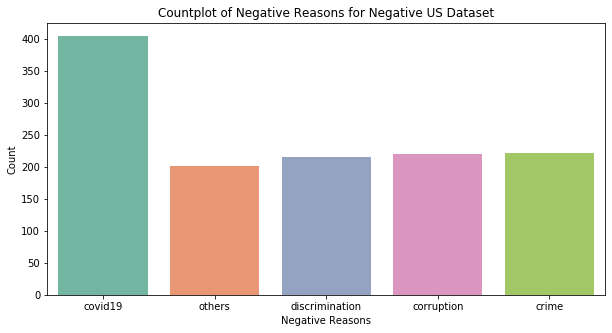

In [146]:
plt.figure(figsize=(10, 5))
sns.countplot(data=negative_us, x="negative_reason", palette="Set2")
plt.title("Countplot of Negative Reasons for Negative US Dataset")
plt.xlabel("Negative Reasons")
plt.ylabel("Count")
plt.show()

This plot illustrates that the biggest reason that people are tweeting negatively is due to the COVID-19 pandemic. Perhaps if the world wasn't going through a pandemic, Americans would be a little bit more positive.

We can break down the above plot into the parties that the twitter users may be affiliated with:

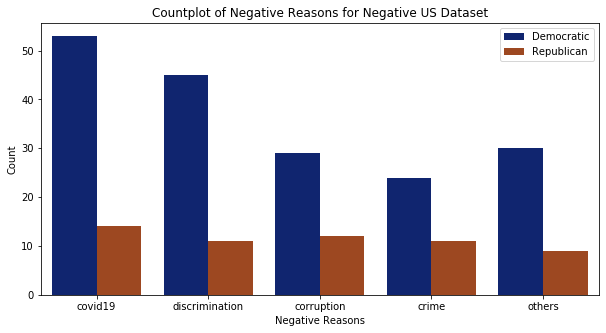

In [142]:
plt.figure(figsize=(10, 5))
negative_us_not_other = negative_us[negative_us["party"] != 2]
sns.countplot(data=negative_us_not_other, x="negative_reason", hue="party", palette="dark")
plt.legend(["Democratic", "Republican"])
plt.title("Countplot of Negative Reasons for Negative US Dataset Split by Party Affiliation")
plt.xlabel("Negative Reasons")
plt.ylabel("Count")
plt.show()

From this plot we can see that, relatively, democrats are more concerned with discrimination whilst republicans are more concerned with corruption. This coincides with the identities of the parties. Recently, the democratic party has been pushing for intersectionality and equality of outcome. To accomplish this, those that adhere to this dogma are more concerned with discrimination. Republicans, on the other hand, are pushing back against intersectionality. Republicans have recently begun to push back against the media, which is predominantly liberal, on grounds of corruption. The current administration has labelled nearly every single news source as "fake news". Therefore, it makes sense that the topic that those with republican affiliation negatively tweet about the most is corruption. 

It is also useful to talk about exactly who these users are. From the snippet below, we can see that based on our identification, these tweets are overwhelmingly democratic:

In [147]:
print("Number of left-leaning tweets:", sum(us_df["party"] == 0))
print("Number of right-leaning tweets:", sum(us_df["party"] == 1))
print("Number of unclassified tweets:", sum(us_df["party"] == 2))

Number of left-leaning tweets: 452
Number of right-leaning tweets: 159
Number of unclassified tweets: 1941


There are a few reasons that this could be. The following is just my speculation. Given that big cities all across America are dominated by democrats, Twitter users are more likely to be democratic than republican. Also, although Trump won the Trump/Clinton election, he did not secure the popular vote. Furthermore, the suburbs and towns outside of the big cities in which blue collar work takes place are dominated by republicans. These republicans may not have access to Twitter or their jobs do not allow for them to spend a considerable amount of time on their phones tweeting. 

Another reason that these tweets are primarily democratic could be that republicans are not comfortable voicing their support for their president. It has become taboo to be a Trump supporter thanks to the popular media in the US. This was a contributing factor to why the polls were wrong in predicting an easy victory for Clinton in 2016. Those that supported Trump did not dare tell anyone for fear of being mocked or socially displaced. A similar phenomena could be occuring in the Twittersphere. 

In terms of the impact of the analysis generated by this report, an excellent prediction model was produced for the purpose of classifying the sentiment of generic tweets. A profoundly high testing accuracy of 93% was obtained. Thus, it is possible to create an accurate model for the purpose of sentiment analysis. 

In [215]:
print(negative_us.shape)

(1264, 6)


- For the second model, provide a few reasons as to why the model may fail to predict the correct negative reasons
    - Back up reasoning with examples from the test set

Well the most prevalent reason that the model fails is because it is completely biased towards predicting "covid19" as the negative reason. This is not without reason, however. "covid19" is the most common negative reason:

In [100]:
print(negative_us["negative_reason"].value_counts())

covid19           405
crime             222
corruption        220
discrimination    215
others            202
Name: negative_reason, dtype: int64


When dealing with an unbalanced dataset it is wise to manually balance it so that the model doesn't just try to predict the mode of the data. Predicting the mode of the data would achieve and accuracy of 32.041%:

In [104]:
print("{}%".format(round(100*405/(405+222+220+215+202), 3)))

32.041%


Our model is only marginally better than this. To fix this, we can upsample the other data by resampling until each of the other negative reason value counts are approximately equal to the "covid19" value count. We could also remove some of the "covid19" records so that the dataset would become balanced in that way. The code below illustrates the precision scores obtained by our model. As illustrated below, the model achieves a 0.82 recall score for "covid19" and abysmal recall scores for the other reasons. 

In [98]:
negative_us = us_df[us_df["sentiment"].astype(float) == False]

# tf-idf
vectorizer = CountVectorizer(max_features=2000)
us_dfx = vectorizer.fit_transform(negative_us["clean_sentences"])

# splitting data
us_dfy = negative_us["negative_reason"]
us_X_train, us_X_test, us_y_train, us_y_test = train_test_split(us_dfx.toarray(), us_dfy, random_state=88, test_size=0.3)

optimal_model = RandomForestClassifier(n_estimators=1000, criterion="gini")
optimal_model.fit(us_X_train, us_y_train)
predictions = optimal_model.predict(us_X_test)

cm = confusion_matrix(us_y_test, predictions)
total = sum(sum(cm))
correct = 0
for i in range(len(cm)):
    correct += cm[i][i]
ACC = correct/total


print("Model Accuracy on Test Set: {}%".format(round(ACC*100,3)))

reason_list = ["corruption", "covid19", "crime", "discrimination", "other"]

cm_df = pd.DataFrame(cm, columns=["corruption_pred", "covid19_pred", "crime_pred", "discrimination_pred", "other_pred"], index=reason_list)

print("\n\n CM DF:\n", cm_df)

cm = np.array(cm)

for i in range(5):
    print(reason_list[i])
    print("precision =", round(cm[i, i]/sum(cm[:, i]), 2))
    print("recall =", round(cm[i, i]/sum(cm[i, :]), 2), "\n")


Model Accuracy on Test Set: 34.211%


 CM DF:
                 corruption_pred  covid19_pred  crime_pred  \
corruption                    9            43           5   
covid19                       5            94           5   
crime                         6            47           8   
discrimination                6            49           2   
other                         2            48           2   

                discrimination_pred  other_pred  
corruption                        1           3  
covid19                           7           4  
crime                             3           6  
discrimination                   13           2  
other                             4           6  
corruption
precision = 0.32
recall = 0.15 

covid19
precision = 0.33
recall = 0.82 

crime
precision = 0.36
recall = 0.11 

discrimination
precision = 0.46
recall = 0.18 

other
precision = 0.29
recall = 0.1 



In [49]:
for index in range(20):
    print("\nInput sentence: {}".format(us_X_test[index]))
    print("Prediction: {}".format(predictions[index]))    
    print("Negative Reason: {}\n".format(us_y_test.iloc[index]))


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: crime
Negative Reason: crime


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: corruption


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: covid19


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: corruption
Negative Reason: corruption


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: corruption
Negative Reason: crime


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: covid19


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: crime
Negative Reason: crime


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: crime


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: covid19


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: corruption


Input sentence: [0. 0. 0. ... 0. 0. 0.]
Prediction: covid19
Negative Reason: discrimination


Input sentence: [0. 0. 0. ... 0.

In [122]:
for i in range(5):
    print("\n\noriginal sentence:\n{}\n\nclean sentence:\n{}\n\nnegative reason = {}\n".format(negative_us["text"].iloc[i], negative_us["clean_sentences"].iloc[i], negative_us["negative_reason"].iloc[i]))

poor_relationship = [0]
mislabelled = [1, 2, 3]



original sentence:
b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'

clean sentence:
afraid nov dec jan bidenharris 2020 win frump ha month damage ha 

negative reason = covid19



original sentence:
b"RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws

clean sentence:
lord sumption launch recovery initiative promote anotherway deal covid hysteria rushed law 

negative reason = others



original sentence:
b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov "when" elected,

clean sentence:
uber timing biden advisor pressure brazil sanction gov elected 

negative reason = covid19



original sentence:
accelerating. &amp; rising when all #Americans killed by #TrumpVirus are https://t.co/QtpgvKI2vp'

clean sentence:
accelerating rising american kille

Another reason for the failures of this model lie in the relationships between the input/output data and the labelling of the output data. Some of the sentences do not bear a clear relationship to the output variable. Consider the following example:

In [123]:
print("\n\noriginal sentence:\n{}\n\nclean sentence:\n{}\n\nnegative reason = {}\n".format(negative_us["text"].iloc[0], negative_us["clean_sentences"].iloc[0], negative_us["negative_reason"].iloc[0]))



original sentence:
b'@robreiner so afraid of Nov, Dec, and Jan! Even if #BidenHarris2020 win...frump has 3 months to do even more damage than he has.'

clean sentence:
afraid nov dec jan bidenharris 2020 win frump ha month damage ha 

negative reason = covid19



The above cleaned sentence does not clearly relate to "covid19". The sentence talks about how "frump has 3 months to do even more damage than he has." It does not specify the context in which "frump" will be doing damage. Unless you had an excellent knowledge of current events and the undertones behind this tweet, it may be difficult to accurately determine that the motive behind this tweet is covid19. 

Consider the following tweets:

In [124]:
print("\n\noriginal sentence:\n{}\n\nclean sentence:\n{}\n\nnegative reason = {}\n".format(negative_us["text"].iloc[1], negative_us["clean_sentences"].iloc[1], negative_us["negative_reason"].iloc[1]))
print("\n\noriginal sentence:\n{}\n\nclean sentence:\n{}\n\nnegative reason = {}\n".format(negative_us["text"].iloc[2], negative_us["clean_sentences"].iloc[2], negative_us["negative_reason"].iloc[2]))
print("\n\noriginal sentence:\n{}\n\nclean sentence:\n{}\n\nnegative reason = {}\n".format(negative_us["text"].iloc[3], negative_us["clean_sentences"].iloc[3], negative_us["negative_reason"].iloc[3]))



original sentence:
b"RT @SueC00K: Lord Sumption launches Recovery - a new initiative to promote #AnotherWay to deal with #Covid. Hysteria and rushed laws

clean sentence:
lord sumption launch recovery initiative promote anotherway deal covid hysteria rushed law 

negative reason = others



original sentence:
b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov "when" elected,

clean sentence:
uber timing biden advisor pressure brazil sanction gov elected 

negative reason = covid19



original sentence:
accelerating. &amp; rising when all #Americans killed by #TrumpVirus are https://t.co/QtpgvKI2vp'

clean sentence:
accelerating rising american killed trumpvirus 

negative reason = discrimination



These sentences aren't even labelled correctly. 

```accelerating. &amp; rising when all #Americans killed by #TrumpVirus are https://t.co/QtpgvKI2vp'```

This sentence is referring to the "#TrumpVirus", in reference to COVID19, but it is labelled as discrimination. 

```b'RT @WalidPhares: Uber Timing: after #Biden advisors said they would put pressure on #Brazil &amp; sanction @jairbolsonaro Gov "when" elected,```

This tweet is referring to how the Biden camp will be putting pressure on the Brazil government in response to human rights issues but it is labelled as "covid19".

Many of these tweets are poorly labelled and this could be a contributing factor as to why the model fails to predict the tweets appropriately. 

- For both models, suggest one way you can improve the accuracy of your models

To improve the accuracy of the first model, we could implement a learned model that takes as input a sequence of word inputs represented by GloVe vectors. This would maintain the locality of the words such that the model could begin to understand double negatives, sarcasm, word locality, and English semantics. 

This could also be implemented for the second model. However, it would likely be more impactful to simply increase the size of the US elections dataset. There are so few tweets in this dataset that the model cannot understand the complex relationships between the input and output. By adding more data these relationships would be captured by the models that were implemented in this report. Also, as mentioned previously, we could upsample/downsample the non-covid/covid negative reason tweets so that the dataset could become more balanced. This would increase the recall of the model accross the other reasons resulting in a more practical model. 

# Bonus: 
## Balanced Sentiment Analysis of Generic Tweets Using N-Grams
Notice from the below confusion matrix breakdown that the recall for a positive sentiment (0.94) is greater than the recall for a negative sentiment (0.91): 

In [15]:
num_features = 2000

# bag of words
# sa_df
vectorizer = CountVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")

model.fit(sa_X_train, sa_y_train)

predictions = model.predict(sa_X_test)

cm = confusion_matrix(sa_y_test, predictions)
total = sum(sum(cm))
correct = 0
for i in range(len(cm)):
    correct += cm[i][i]
ACC = correct/total


print("Model Accuracy: {}%".format(round(ACC*100,3)))


cm_df = pd.DataFrame(cm, columns=["0_pred", "1_pred"], index=[0, 1])

print("\n\n CM DF:\n", cm_df)

cm = np.array(cm)

print("\n")
for i in range(2):
    print("sentiment =", i)
    print("precision =", round(cm[i, i]/sum(cm[:, i]), 2))
    print("recall =", round(cm[i, i]/sum(cm[i, :]), 2), "\n")

Model Accuracy: 93.005%


 CM DF:
    0_pred  1_pred
0    9781     998
1    1312   20933


sentiment = 0
precision = 0.88
recall = 0.91 

sentiment = 1
precision = 0.95
recall = 0.94 



Also notice that there are far more positive tweets than negative tweets:

In [163]:
print(sa_df["label"].value_counts())

1    371341
0    179050
Name: label, dtype: int64


Therefore, for the bonus, I will balance the data such that both the positive and negative sentiments appear approximately the same number of times:

In [16]:
from sklearn.utils import resample

sa_df_neg = sa_df[sa_df["label"].astype(int) == 0]
sa_df_pos = sa_df[sa_df["label"].astype(int) == 1]

print(sa_df_neg["label"].value_counts())
print(sa_df_pos["label"].value_counts())

sa_df_neg_upsampled = resample(sa_df_neg, replace=True, n_samples=371341, random_state=88)

0    179050
Name: label, dtype: int64
1    371341
Name: label, dtype: int64


In [17]:
sa_df_upsampled = pd.concat([sa_df_neg_upsampled, sa_df_pos])

print(sa_df_upsampled["label"].value_counts())

0    371341
1    371341
Name: label, dtype: int64


In [18]:
sa_df_sample_indices = sample_without_replacement(n_population=sa_df_upsampled.shape[0], n_samples=round(sa_df_upsampled.shape[0]/5), random_state=88) 

sa_df_sample = sa_df_upsampled.iloc[sa_df_sample_indices]
print(sa_df_sample.shape)

(148536, 5)


In [19]:
num_features = 2000

# bag of words
# sa_df
vectorizer = CountVectorizer(max_features=num_features)
sa_dfx = vectorizer.fit_transform(sa_df_sample["clean_sentences"])
# us_df
us_dfx = vectorizer.transform(us_df["clean_sentences"])

# splitting data
sa_dfy = sa_df_sample["label"]
sa_X_train, sa_X_test, sa_y_train, sa_y_test = train_test_split(sa_dfx.toarray(), sa_dfy, random_state=88, test_size=0.3)

# logistic regression
model = LogisticRegression(solver="liblinear", multi_class="auto")

model.fit(sa_X_train, sa_y_train)

predictions = model.predict(sa_X_test)

cm = confusion_matrix(sa_y_test, predictions)
total = sum(sum(cm))
correct = 0
for i in range(len(cm)):
    correct += cm[i][i]
ACC = correct/total


print("Model Accuracy: {}%".format(round(ACC*100,3)))


cm_df = pd.DataFrame(cm, columns=["0_pred", "1_pred"], index=[0, 1])

print("\n\n CM DF:\n", cm_df)

cm = np.array(cm)

print("\n")
for i in range(2):
    print("sentiment =", i)
    print("precision =", round(cm[i, i]/sum(cm[:, i]), 2))
    print("recall =", round(cm[i, i]/sum(cm[i, :]), 2), "\n")

Model Accuracy: 93.088%


 CM DF:
    0_pred  1_pred
0   21064    1061
1    2019   20417


sentiment = 0
precision = 0.91
recall = 0.95 

sentiment = 1
precision = 0.95
recall = 0.91 



From the above, we can see that the model's negative sentiment precision increased from 0.88 to 0.91. Further, the accuracy of the model increased from 93.005% to 93.088%. This shows that by balancing an unbalanced dataset we can increase the precision of the model in the under-represented columns and improve the overall accuracy of the model.  